In [5]:
# Importing necessary packages for data visualization, statistics, and time series analysis
import warnings  # For filtering out warnings
warnings.filterwarnings("ignore")

# Importing basic packages for data manipulation and analysis
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import datetime

# Importing packages for data visualization
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualizations
import plotly.express as px  # For Plotly plots
%matplotlib inline

# Importing package for statistical analysis
from statsmodels.distributions.empirical_distribution import ECDF  # For empirical distribution function

# Importing package for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose  # For seasonal decomposition of time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots

# Importing package for time series forecasting
from prophet import Prophet  # For time series forecasting using Prophet by Facebook


In [6]:
import os

# Get the current working directory (where your notebook file and data files are located)
current_directory = os.getcwd()

# Traverse the directory to list all files
for dirname, _, filenames in os.walk(current_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\sales prediction\sales_prediction.ipynb
D:\sales prediction\store.csv
D:\sales prediction\test.csv
D:\sales prediction\train.csv
D:\sales prediction\.ipynb_checkpoints\sales_prediction-checkpoint.ipynb
D:\sales prediction\.ipynb_checkpoints\train-checkpoint.csv


In [7]:
#train dataset
train = pd.read_csv('D:/sales prediction/train.csv',
                   parse_dates = ['Date'], index_col = 'Date')
#additional dataset
store = pd.read_csv('D:/sales prediction/store.csv')

test = pd.read_csv('D:/sales prediction/test.csv')

#time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [8]:
print('Train:', train.shape),
print('Store:', store.shape)
train.head(5)

Train: (1017209, 8)
Store: (1115, 10)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [9]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [10]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week

In [11]:
# We can calculate sale per customer to compare stores correctly.
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

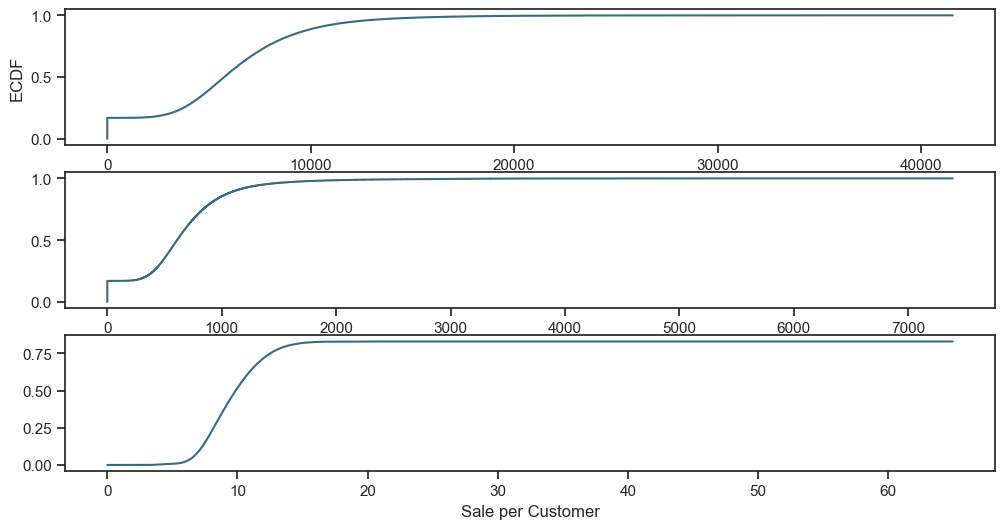

In [12]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [13]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [14]:
print(train[(train.Open == 0) & (train.Sales == 0)].shape)

(172817, 13)


In [15]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [16]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [17]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
# missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [19]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [20]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [21]:
# Filter stores with missing 'Promo2SinceWeek' values (no promo info)
promo = store[store['Promo2SinceWeek'].isnull()]

# Filter stores with non-zero 'Promo2' values (stores with active promos)
promo_active = promo[promo['Promo2'] != 0]

# Get the shape (number of rows and columns) of the filtered dataframe
promo_active_shape = promo_active.shape

# Print the shape
print(promo_active_shape)

(0, 10)


In [22]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [23]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [24]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [25]:
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


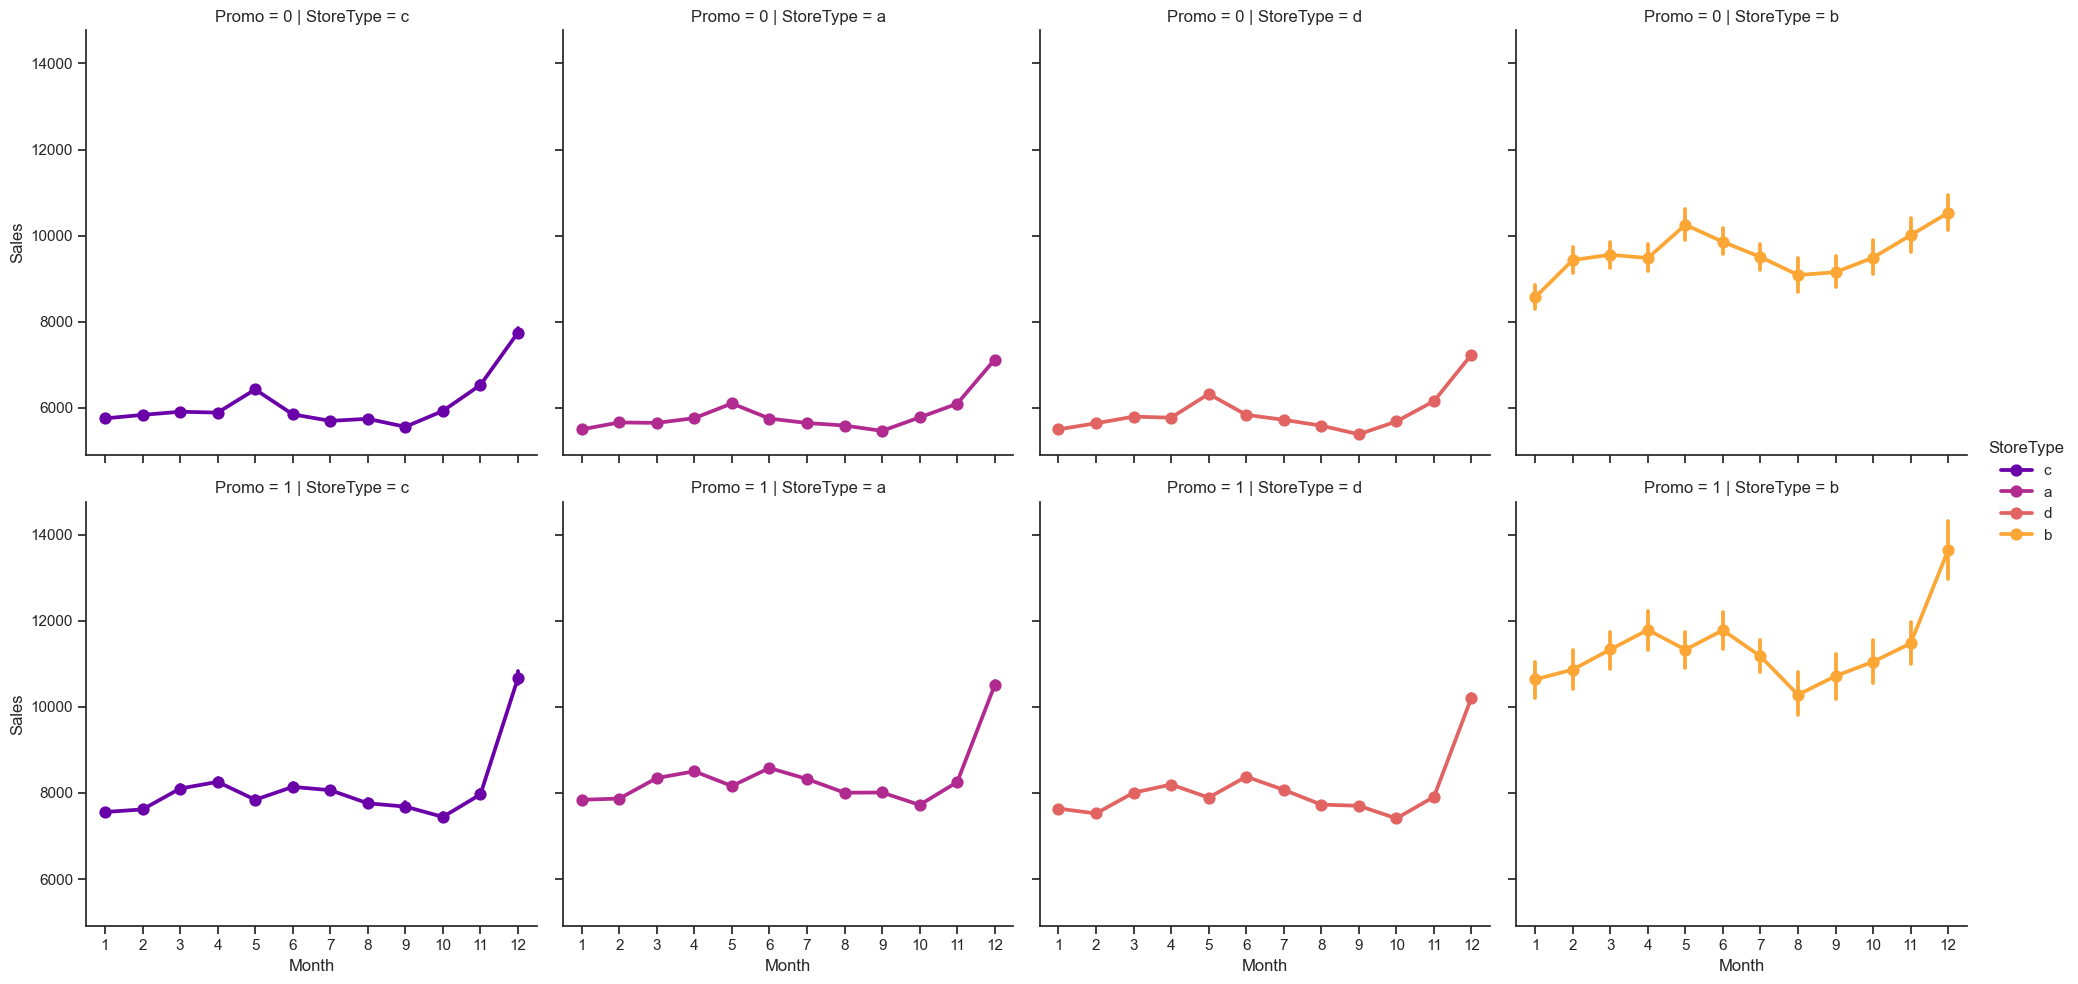

In [26]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind='point') 

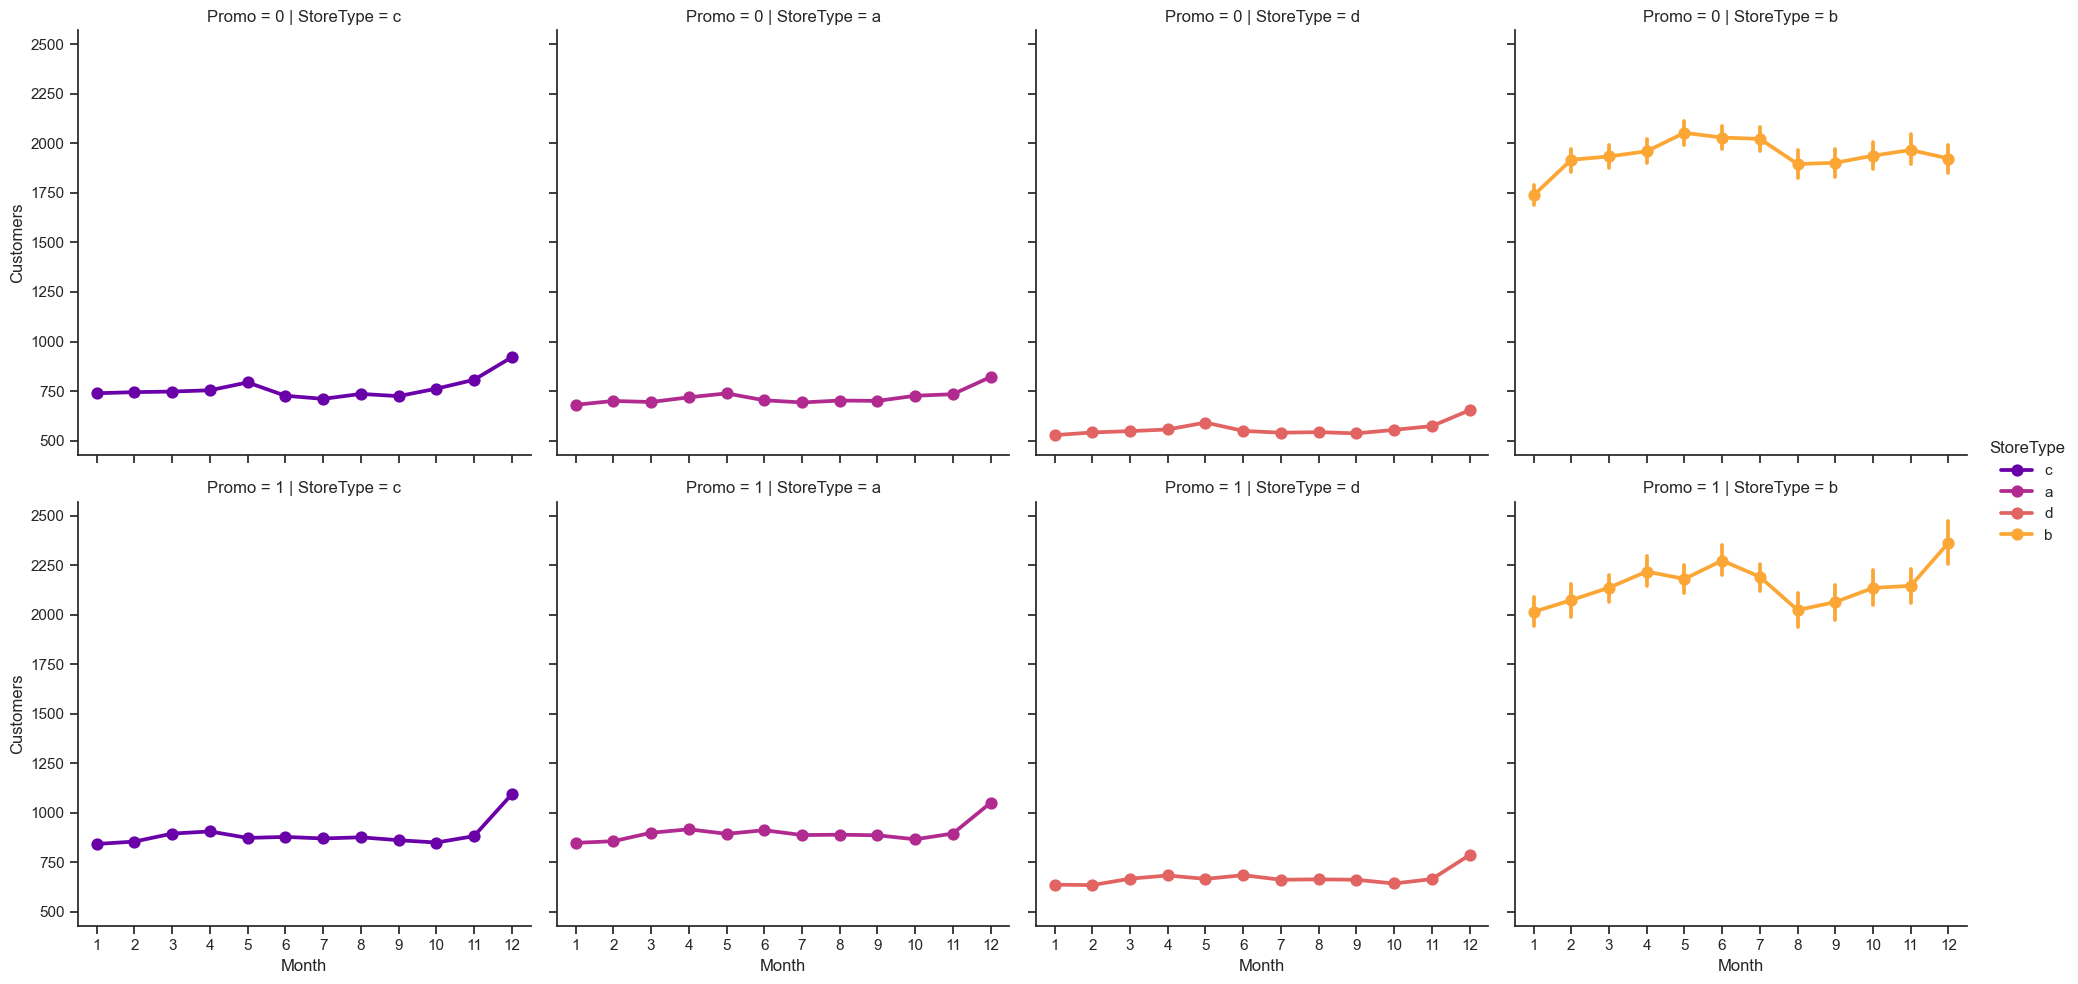

In [27]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind='point') 

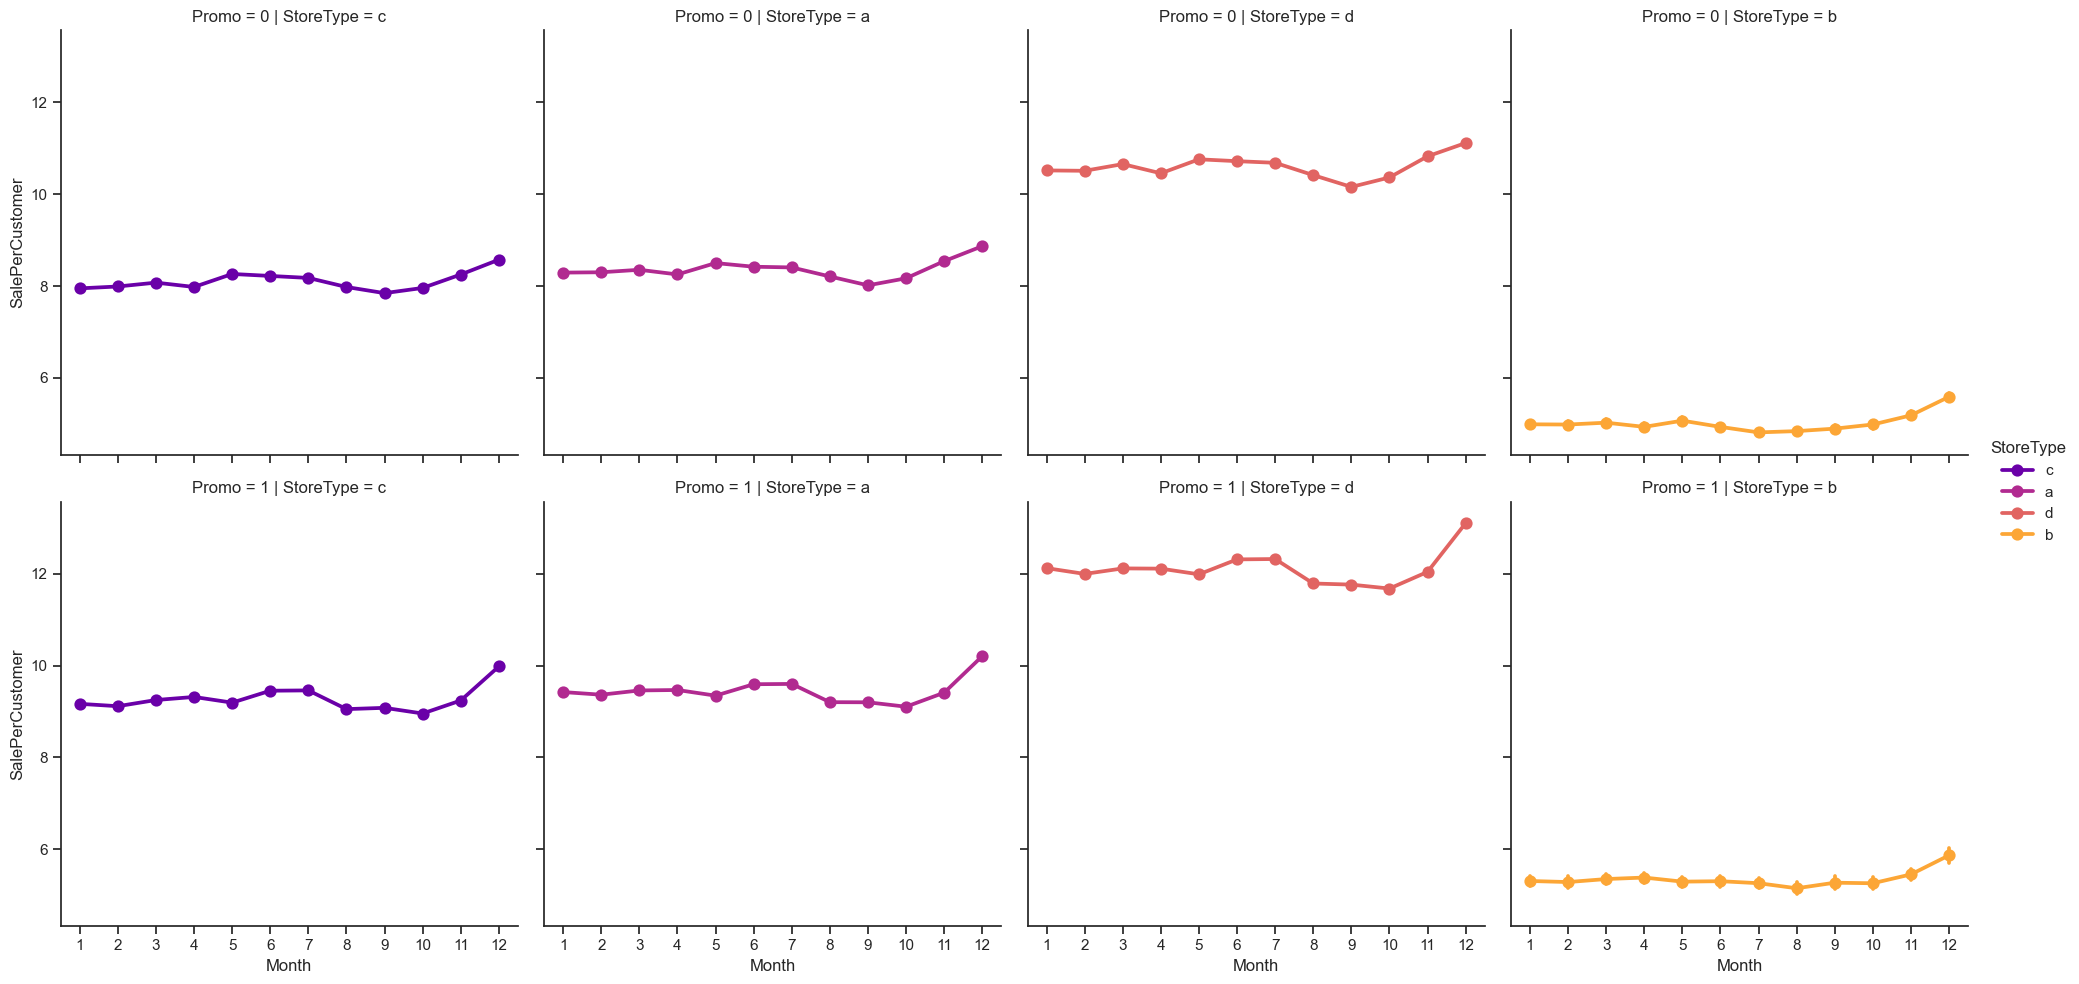

In [28]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind='point') 

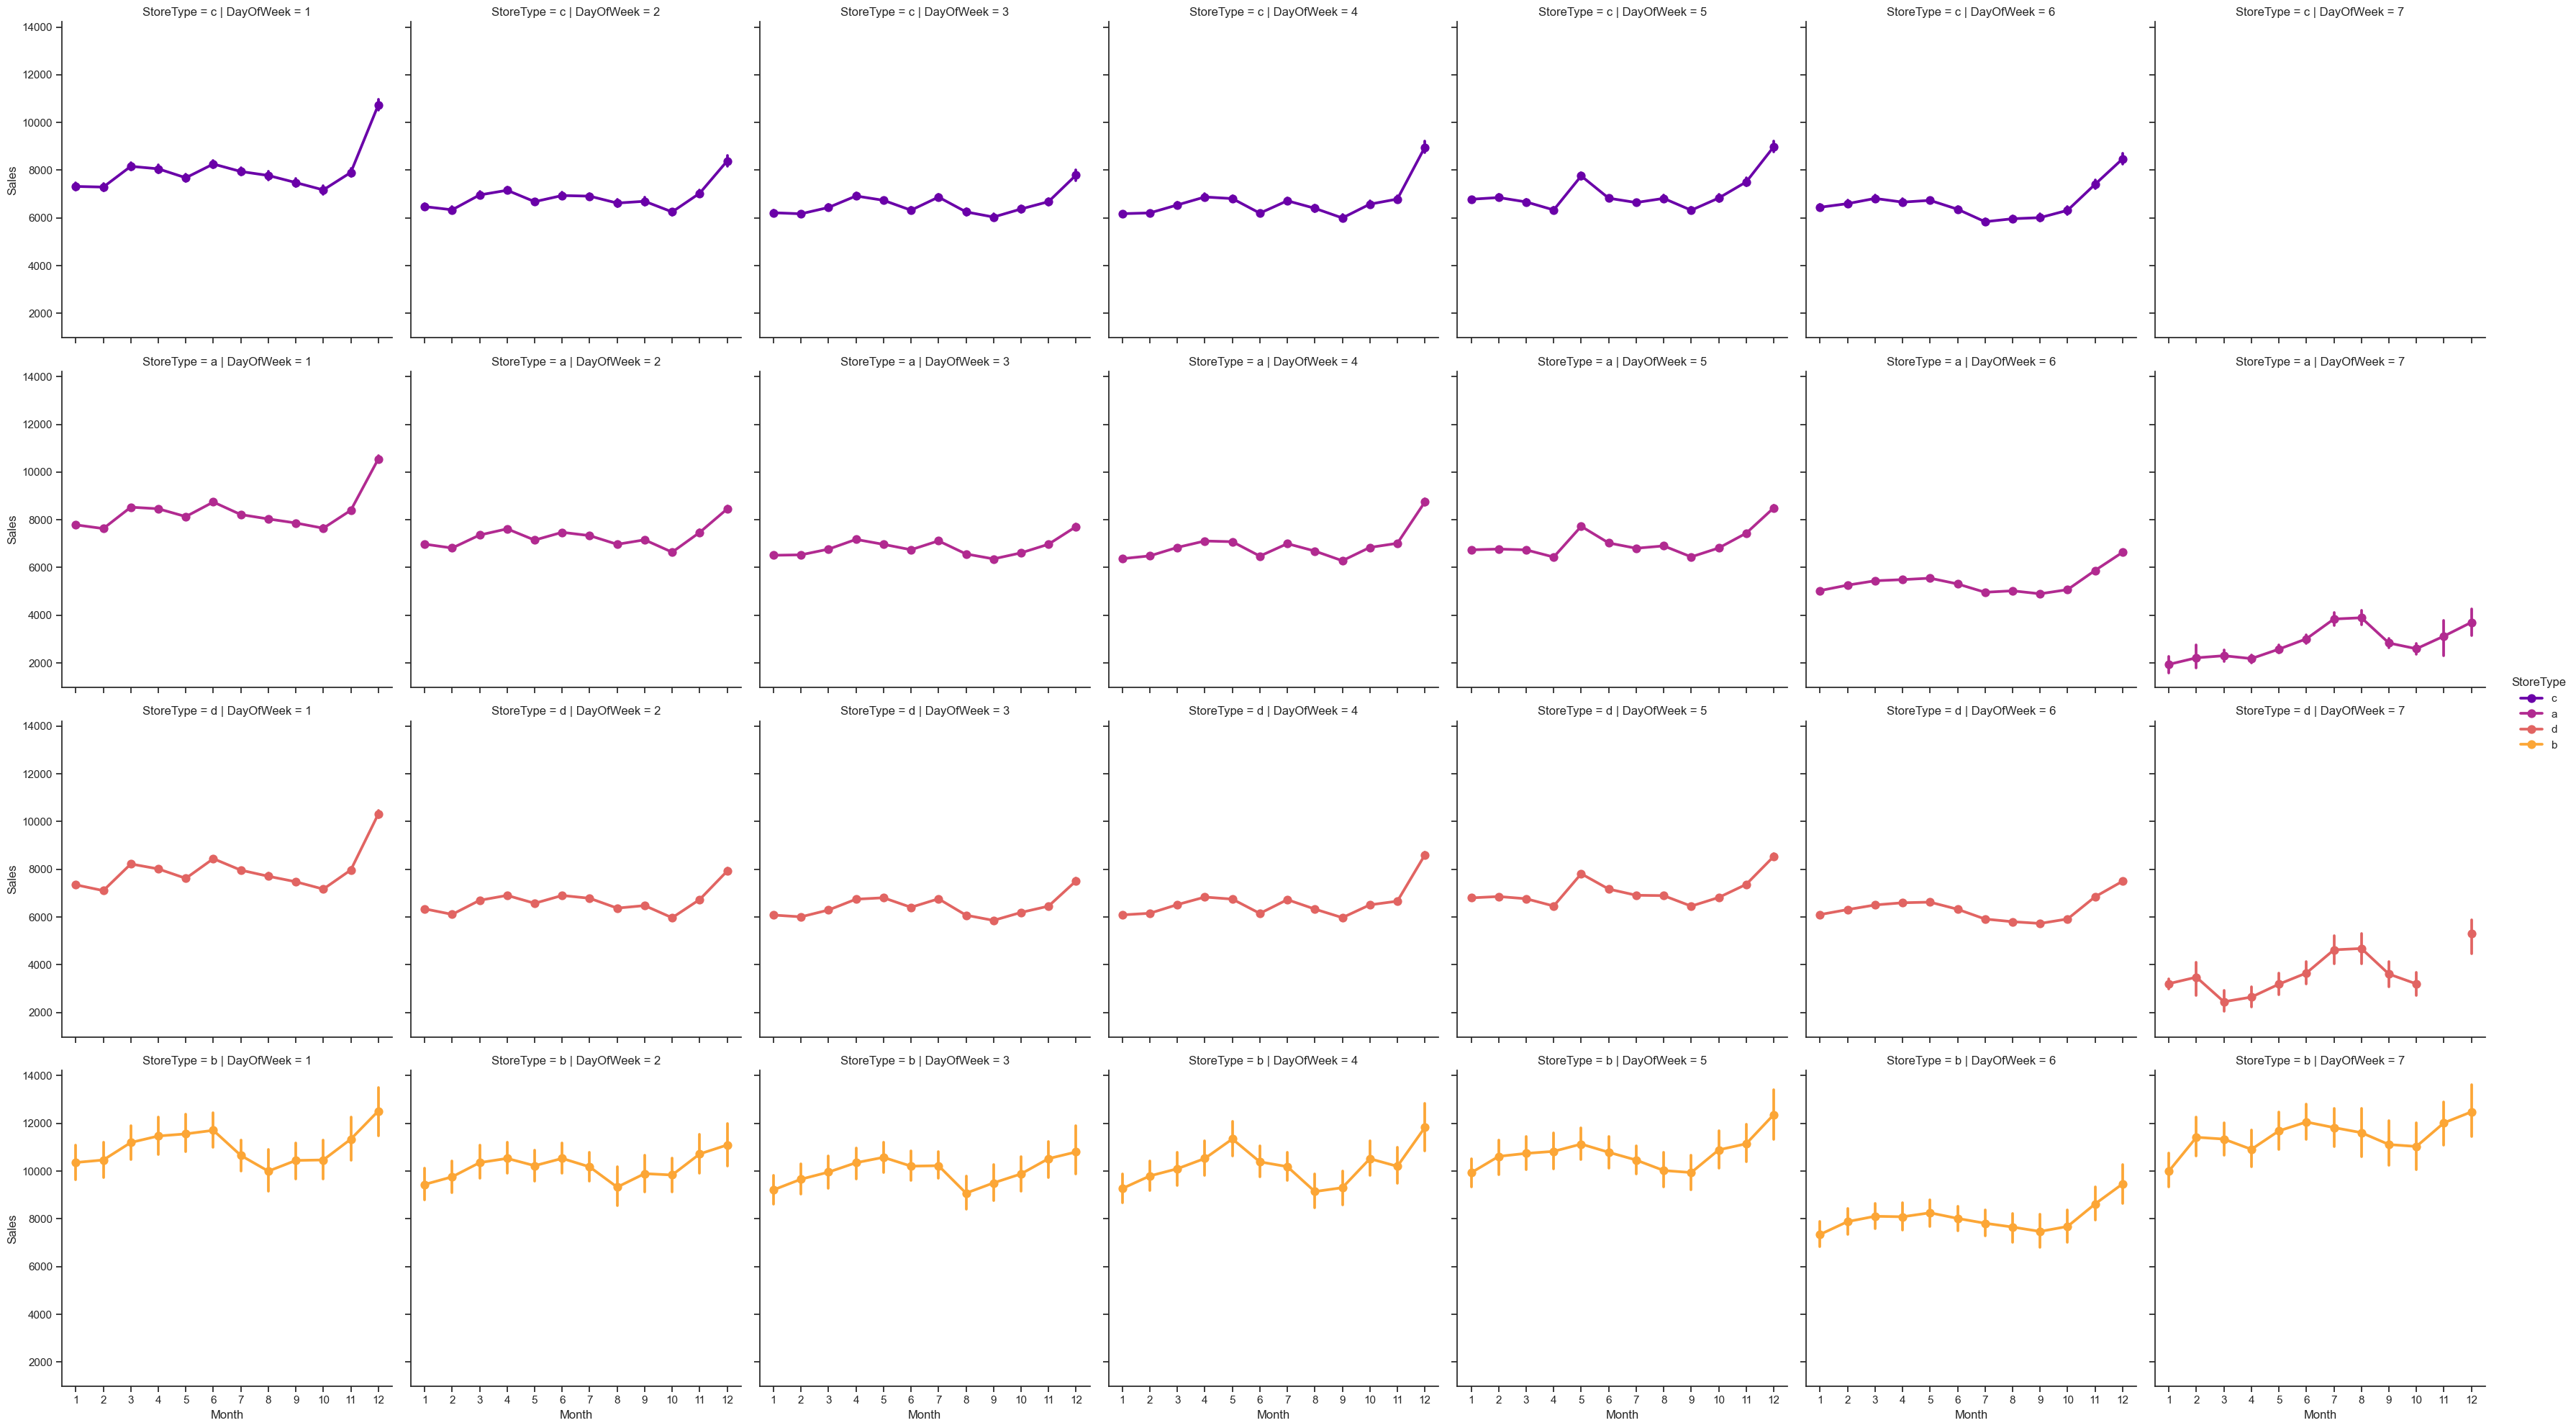

In [29]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c,
               kind= 'point') 


In [30]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877],
      dtype=int64)

In [31]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


In [32]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
1,2,5,6064,625,1,1,0,1,2015,7,...,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",92.0,64.5
2,3,5,8314,821,1,1,0,1,2015,7,...,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",103.0,52.25
3,4,5,13995,1498,1,1,0,1,2015,7,...,c,620.0,9.0,2009.0,0,0.0,0.0,0,70.0,24187.75
4,5,5,4822,559,1,1,0,1,2015,7,...,a,29910.0,4.0,2015.0,0,0.0,0.0,0,3.0,24187.75


In [33]:
for col in train_store[['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']]:
    unique_values = train_store[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")

Unique values in column 'StateHoliday': ['0' 'a' 'b' 'c' 0]
Unique values in column 'StoreType': ['c' 'a' 'd' 'b']
Unique values in column 'Assortment': ['a' 'c' 'b']
Unique values in column 'PromoInterval': [0 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [34]:
print(train_store.dtypes)
train_store[['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']]

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
Year                           int32
Month                          int32
Day                            int32
WeekOfYear                    UInt32
SalePerCustomer              float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpen              float64
PromoOpen                    Float64
dtype: object


,StateHoliday,StoreType,Assortment,PromoInterval
0,0,c,a,0
1,0,a,a,"Jan,Apr,Jul,Oct"
2,0,a,a,"Jan,Apr,Jul,Oct"
3,0,c,c,0
4,0,a,a,0
...,...,...,...,...
844333,a,b,a,0
844334,a,b,b,0
844335,a,b,b,"Jan,Apr,Jul,Oct"
844336,a,b,b,0


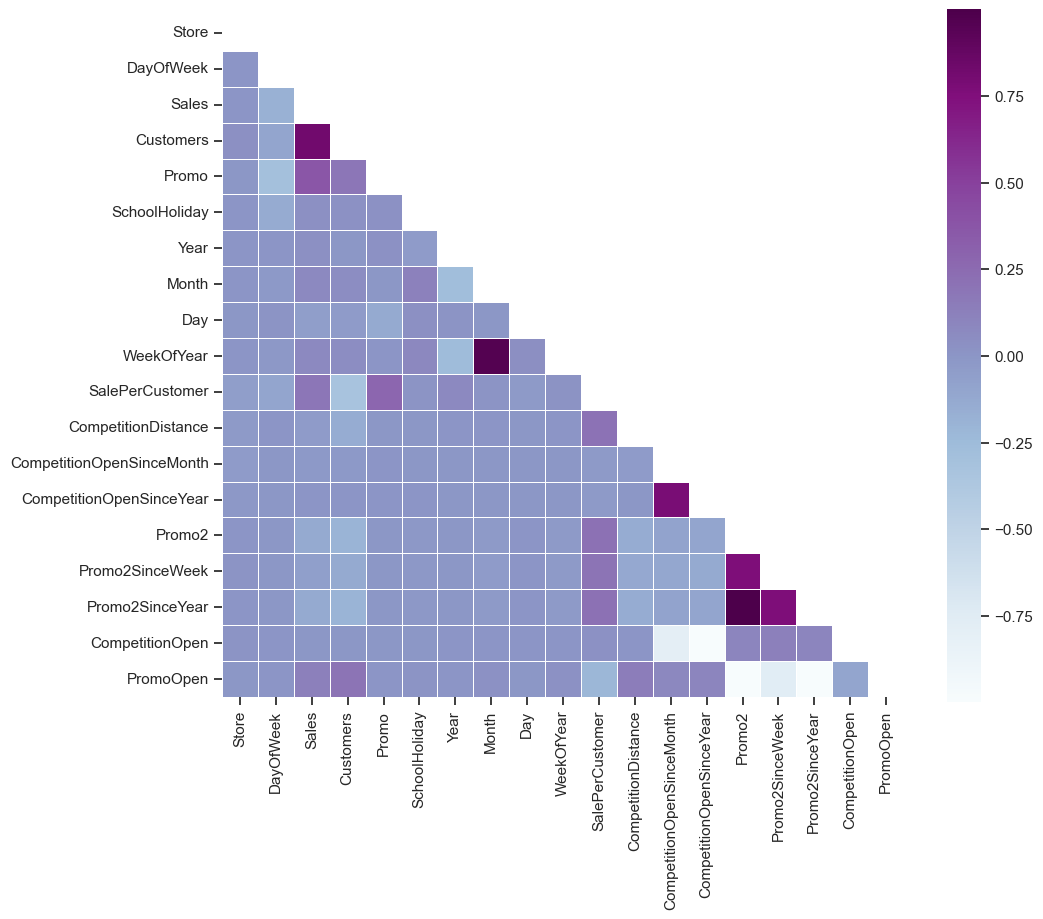

In [35]:
# Compute the correlation matrix 
# exclude 'Open' variable
numerical_columns = train_store.select_dtypes(include=[np.number])  #Some variables are still object
                                                                    # (['StateHoliday', 'StoreType',                                                                #'Assortment', 'PromoInterval']) We will exclude them.
corr_all = numerical_columns.drop(['Open'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

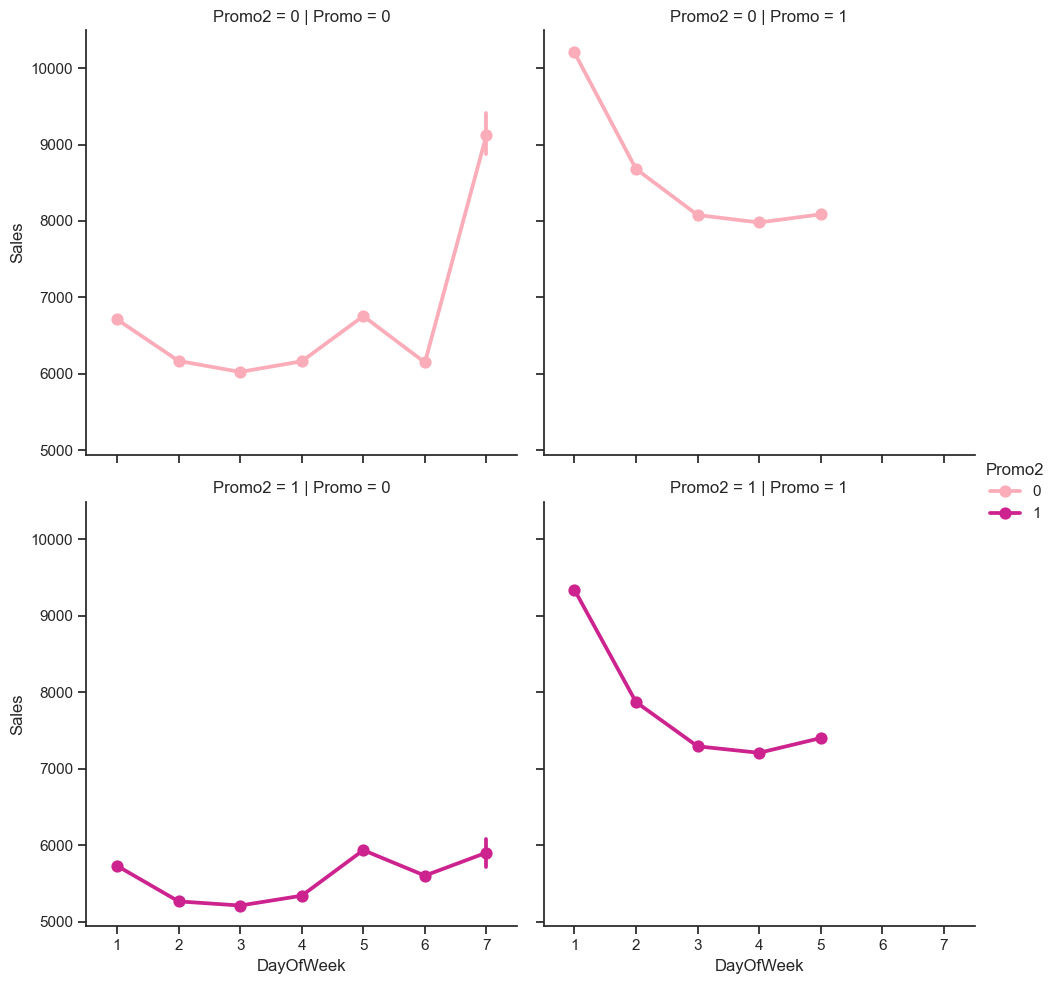

In [36]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu',
               kind='point') 

<Axes: xlabel='Date'>

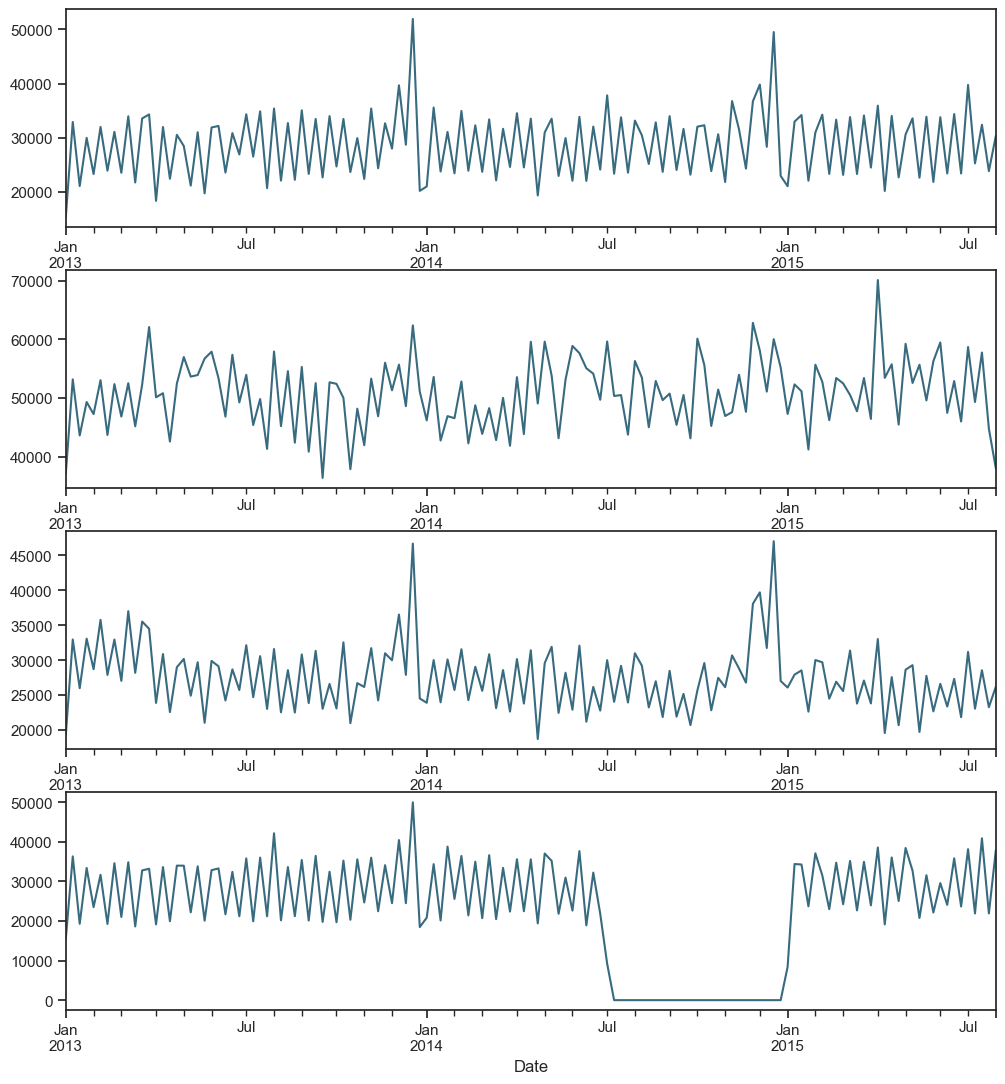

In [37]:
# preparation: input should be float type
train['Sales'] = train['Sales'].astype(float)

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending=True)  # Solve reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Weekly resampling and plotting
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))
sales_a.resample('W').sum().plot(color=c, ax=ax1)
sales_b.resample('W').sum().plot(color=c, ax=ax2)
sales_c.resample('W').sum().plot(color=c, ax=ax3)
sales_d.resample('W').sum().plot(color=c, ax=ax4)

In [38]:
sales_d

Date
2015-07-31    8821.0
2015-07-30    7648.0
2015-07-29    6648.0
2015-07-28    6819.0
2015-07-27    7926.0
               ...  
2013-01-07    8246.0
2013-01-05    4285.0
2013-01-04    3848.0
2013-01-03    3674.0
2013-01-02    3737.0
Name: Sales, Length: 621, dtype: float64

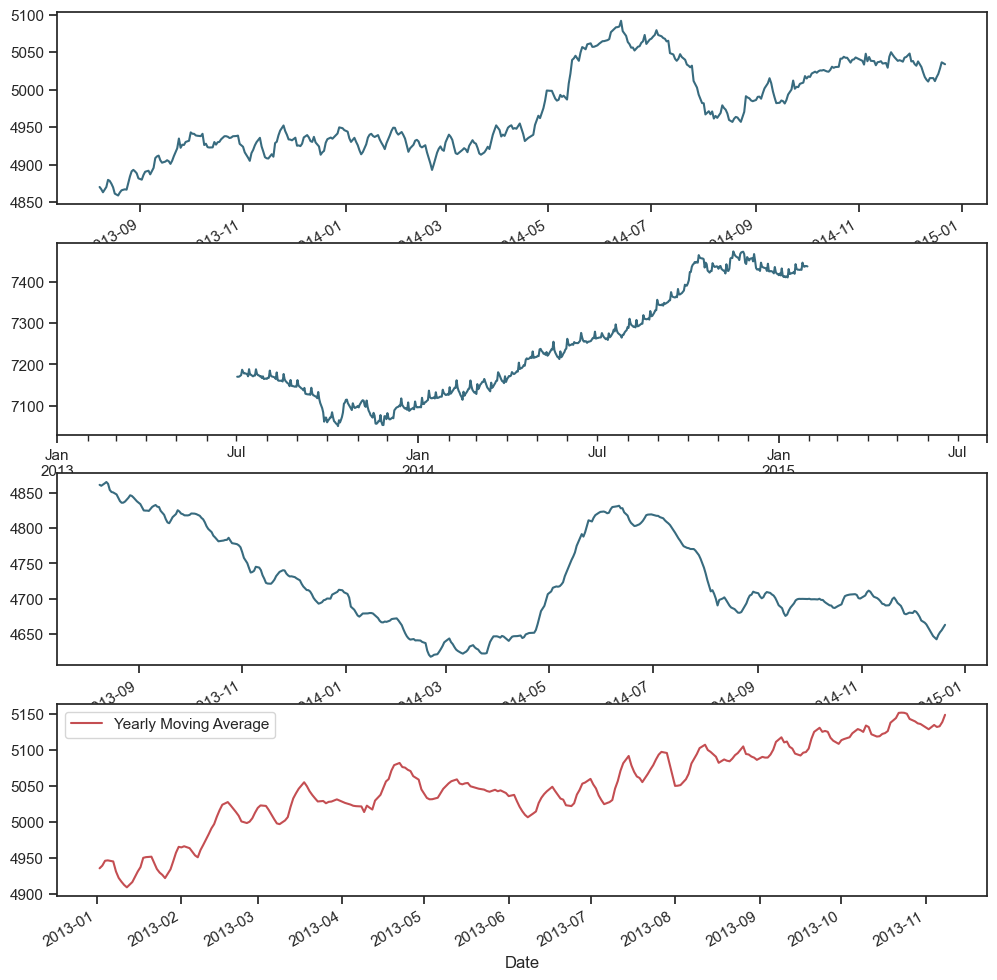

In [39]:
# Monthly seasonal decomposition
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))
decomposition_a = seasonal_decompose(sales_a, model='additive', period=365)
decomposition_a.trend.plot(color=c, ax=ax1)

decomposition_b = seasonal_decompose(sales_b, model='additive', period=365)
decomposition_b.trend.plot(color=c, ax=ax2)

decomposition_c = seasonal_decompose(sales_c, model='additive', period=365)
decomposition_c.trend.plot(color=c, ax=ax3)

# Handle insufficient data in sales_d:
if len(sales_d) >= 730:
    # Perform seasonal decomposition if data is sufficient
    decomposition_d = seasonal_decompose(sales_d, model='additive', period=365)
    decomposition_d.trend.plot(color=c, ax=ax4)
else:
    # Choose an alternative approach (e.g., moving average)
    sales_d_ma = sales_d.rolling(window=365).mean()
    sales_d_ma.plot(color='r', label='Yearly Moving Average', ax=ax4)
    plt.legend()

plt.show()

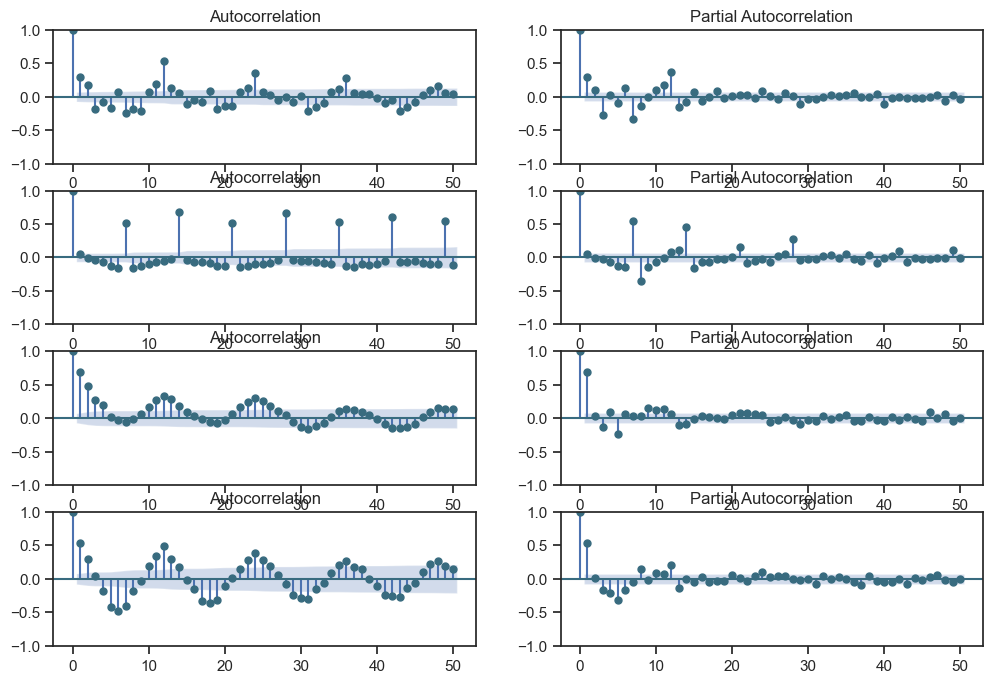

In [40]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

In [41]:
# importing data
df = pd.read_csv('D:/sales prediction/train.csv', low_memory=False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [42]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


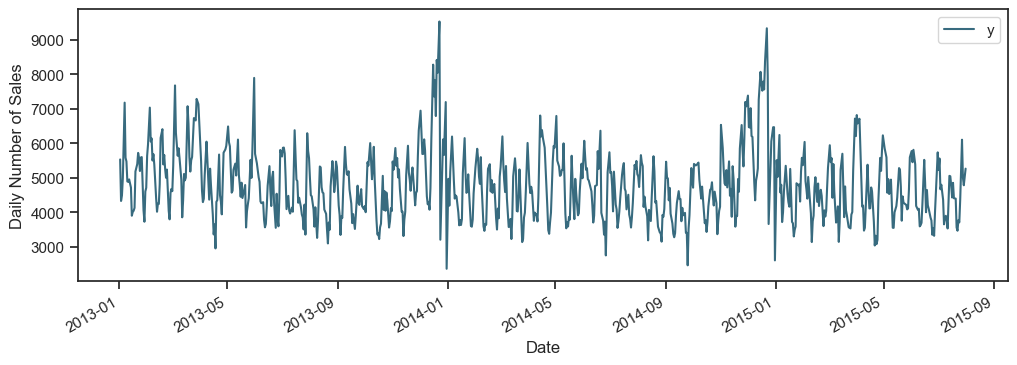

In [43]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()


In [44]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [45]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

11:09:47 - cmdstanpy - INFO - Chain [1] start processing
11:09:47 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [46]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4109.292747,2463.294824,5760.464619
817,2015-09-06,4081.942351,2418.002488,5646.872319
818,2015-09-07,4179.728666,2535.518314,5828.471762
819,2015-09-08,3682.159219,2058.667885,5299.721689
820,2015-09-09,3568.378519,1935.976221,5213.812812
821,2015-09-10,3480.584575,1802.374543,5181.831559
822,2015-09-11,3735.707342,2091.102648,5257.479946


In [47]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

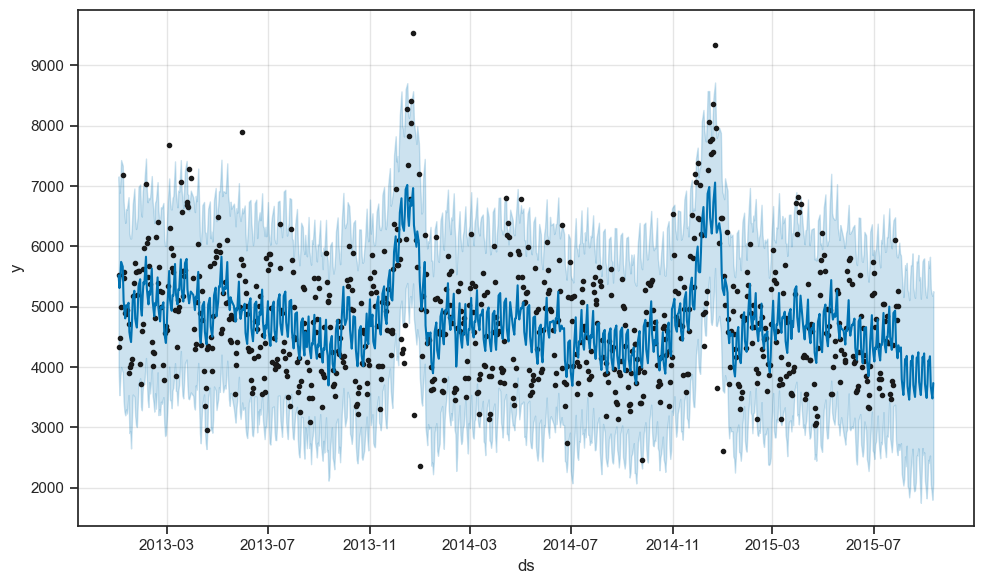

In [48]:
# visualizing predicions
my_model.plot(forecast);

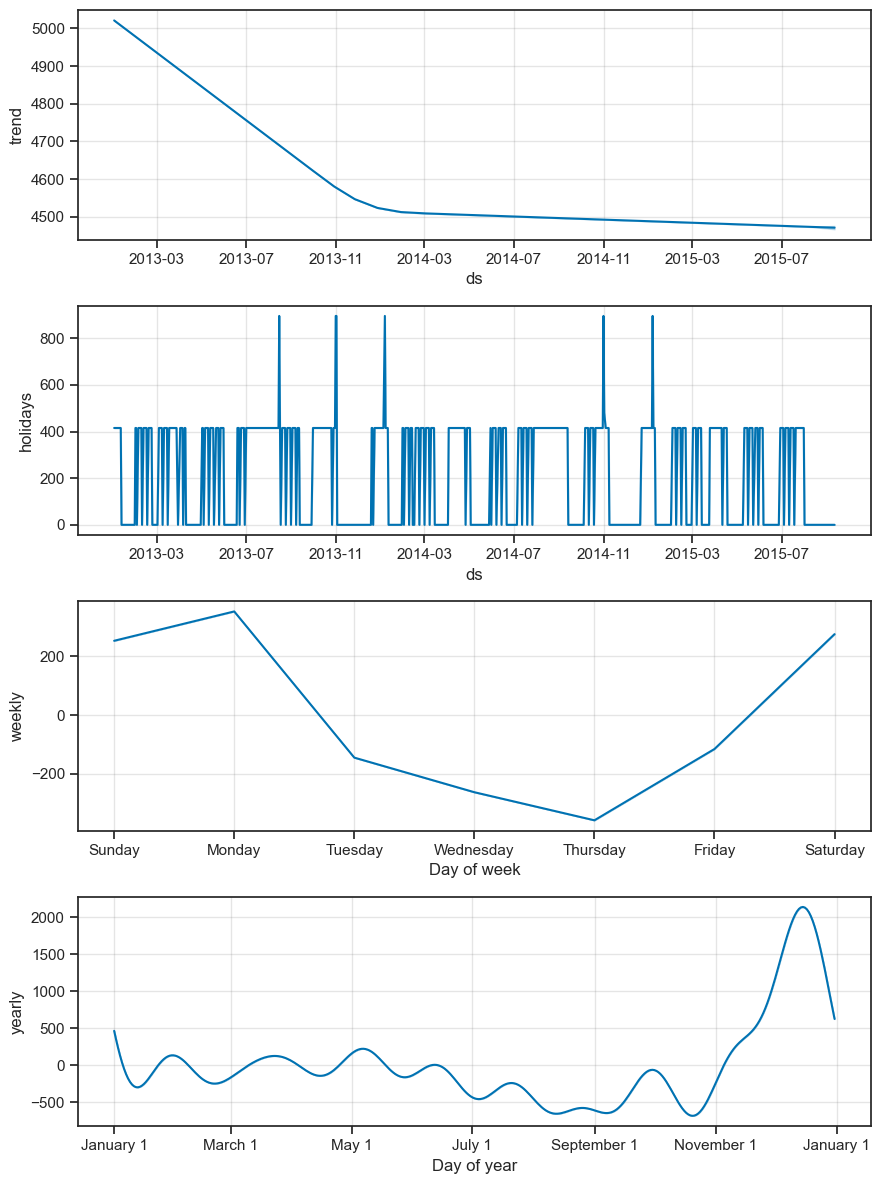

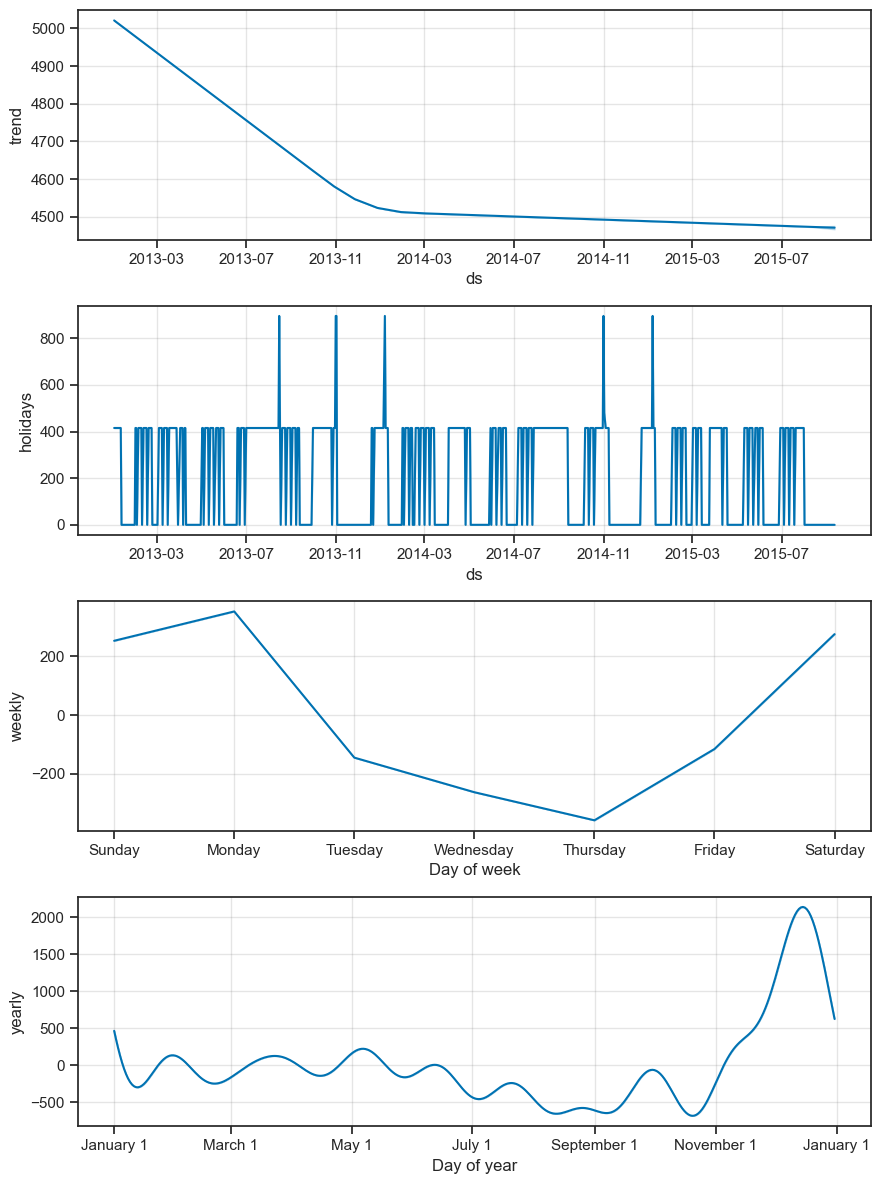

In [49]:
my_model.plot_components(forecast)

In [50]:
fc.head()

,ds,yhat
0,2013-01-02,5519.800763
1,2013-01-03,5309.677298
2,2013-01-04,5447.630243
3,2013-01-05,5744.196621
4,2013-01-07,5665.331814


In [59]:
print(fc.head())
print(fc.columns)

   Id  Id  Id  Id  Id         ds         yhat
0   0   0   0   0   0 2013-01-02  5519.800763
1   1   1   1   1   1 2013-01-03  5309.677298
2   2   2   2   2   2 2013-01-04  5447.630243
3   3   3   3   3   3 2013-01-05  5744.196621
4   4   4   4   4   4 2013-01-07  5665.331814
Index(['Id', 'Id', 'Id', 'Id', 'Id', 'ds', 'yhat'], dtype='object')


In [60]:
fc = fc.loc[:, ~fc.columns.duplicated()]

In [61]:
fc = fc.reset_index(drop=True)  # Reset index and drop the old one
fc.rename(columns={'index': 'Id'}, inplace=True)  # Rename index only if needed

In [63]:
# Reset index only if necessary
if 'Id' not in fc.columns:
    fc = fc.reset_index(drop=False)

# Remove duplicate columns
fc = fc.loc[:, ~fc.columns.duplicated()]

# Check column names and inspect the DataFrame
print("Columns in DataFrame:", fc.columns)
print(fc.head())

# Select relevant columns for submission
submission = fc[['Id', 'yhat']]

# Rename 'yhat' to 'Sales' if required for the submission format
submission.rename(columns={'yhat': 'Sales'}, inplace=True)

# Export to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")

Columns in DataFrame: Index(['Id', 'ds', 'yhat'], dtype='object')
   Id         ds         yhat
0   0 2013-01-02  5519.800763
1   1 2013-01-03  5309.677298
2   2 2013-01-04  5447.630243
3   3 2013-01-05  5744.196621
4   4 2013-01-07  5665.331814
Submission file 'submission.csv' created successfully!
